In [64]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmphol2smzk/pubring.gpg' created
gpg: /tmp/tmphol2smzk/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [65]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [66]:
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

!pip install keras

In [0]:
###############################################################################
# Libraries import
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import cv2

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
from keras import backend as K
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator
K.set_image_dim_ordering('th')
###############################################################################


In [68]:
# Give a name to id the data used in this training
# use the name of validation driver

# These are the randomly selected validation divisions created from driver ids:

valid_ids= [['p066', 'p021', 'p024'],
 ['p026', 'p072', 'p015'],
 ['p052', 'p061', 'p042', 'p081'],
 ['p016', 'p041', 'p050'],
 ['p047', 'p064', 'p035'],
 ['p049', 'p002', 'p012', 'p039'],
 ['p056', 'p051', 'p022'],
 ['p075', 'p014', 'p045']]


# Select the validation id group to use for this particular training

i=7
print(valid_ids[i])


# generate file name to identify the valid ids group used

if len(valid_ids[i]) == 3:
  train_data_filename = str(valid_ids[i][0] + "_" + valid_ids[i][1] + "_" +
                         valid_ids[i][2] + "_1_96_128")
else:
  train_data_filename = str(valid_ids[i][0] + "_" + valid_ids[i][1] + "_" +
                          valid_ids[i][2] + "_" + valid_ids[i][3] + "_1_96_128")
    

print(train_data_filename)

# generate location address for train data
train_file_address =  str("drive/Colab_Notebooks/x_train_" + train_data_filename + ".pk1")
train_file_address2 =  str("drive/Colab_Notebooks/y_train_xy_valid_" + train_data_filename + ".pk1")

print(train_file_address)
print(train_file_address2)


# Create a validation prediction file for dashboard and other visualization 
# Read the original drivers_img_list for validation drivers only
# Short by validation driver in this particular dataset


# Read the full drivers list
train_driver_list = pd.read_csv('drive/Colab_Notebooks/Data/driver_imgs_list.csv')

# filter out only drivers from the validation set
valid_df =train_driver_list.loc[train_driver_list['subject'].isin(valid_ids[i])]



['p075', 'p014', 'p045']
p075_p014_p045_1_96_128
drive/Colab_Notebooks/x_train_p075_p014_p045_1_96_128.pk1
drive/Colab_Notebooks/y_train_xy_valid_p075_p014_p045_1_96_128.pk1


In [0]:
# Import and read data fromm pickle sets
import pickle
with open (train_file_address, 'rb') as f:
    x_train = pickle.load(f)
       
with open (train_file_address2, 'rb') as f:
    y_train = pickle.load(f)
    x_valid = pickle.load(f)
    y_valid = pickle.load(f)


In [70]:
# Verify data shape
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(20010, 1, 96, 128)
(20010, 10)
(2414, 1, 96, 128)
(2414, 10)


In [0]:
# Name the model type to id weights and results
Model_type =  "simple_NN"


In [72]:
# Define some image and class parameters
# color type: 1 = grey, 3 = rgb
color_type = 1
img_rows, img_cols = 96, 128
nb_classes = 10  # 2 for "imgs_sub2"; 10 for others

input_dim = img_rows * img_cols

print(input_dim)
##############################################################################

12288


In [0]:
# reshape images for the Logistic Regression

X_train = x_train.reshape(len(x_train), input_dim) 
X_valid = x_valid.reshape(len(x_valid), input_dim) 
X_train = X_train.astype('float32') 
X_valid = X_valid.astype('float32') 

In [0]:
# Set model batch size and epoch parameters.
batch_size =250
nb_epoch =100
output_dim = nb_classes = 10 


In [1]:
# create a convolution model with keras

from keras.optimizers import SGD, Adam, Adadelta, Adamax, RMSprop

# Key to select if using as-is data(transposed, resize, grey scale) Or
# if using augmented data.  (0 for as-is, 1 for augmented)

augm_data = 0

print(batch_size)


# read saved model, if any
model_from_cache = 0
if model_from_cache == 1:
    model = read_model()
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')
else:
    
    model = Sequential() 
    model.add(Dense(512, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(nb_classes, activation='softmax')) 
    
    adadel = Adadelta(lr=0.59, rho=0.95, epsilon=None, decay=0.0)
    
    sgd = SGD(lr=0.0008, momentum=0.35, decay=0.00000001, nesterov=True)
    
    rms = RMSprop(lr=0.001, rho=0.08, epsilon=None, decay=0.00001)
    
    adam =  Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

    
    model.summary()
    
    # compile and train model
    model.compile(loss='categorical_crossentropy', optimizer= sgd , metrics=['accuracy'])

    if augm_data ==  0:
        # For Non-augmented data
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch,
                  verbose=1, validation_data=(X_valid, y_valid))
    else:
    # for augmented data
        history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                            epochs=nb_epoch,
                            verbose=1, steps_per_epoch=len(x_train)/batch_size, 
                            validation_data=(X_valid, y_valid))

model.summary()  # get model summary
 
###############################################################################





Using TensorFlow backend.


NameError: ignored

In [39]:
# Score model on train and validation sets.
# Create a dataframe to stroe the results from the training
# Plot training results
train_score = model.evaluate(X_train, y_train, verbose=0)
print('train score: ', train_score)

valid_score = model.evaluate(X_valid, y_valid, verbose=0)
print('valid score: ', valid_score)

train score:  [0.21797317031404187, 0.9717641179410295]
valid score:  [1.8943567036989808, 0.45650372825186414]


In [0]:
# Name the model type to id weights and results
Model_type = "simple_2layer_NN"

In [41]:
# Save weights if model is acceptable

# serialize weights to HDF5
weights_filename = 'drive/Colab_Notebooks/Models/' + Model_type + "_" + train_data_filename + '_weights.h5'
print(str(weights_filename))
model.save_weights(weights_filename)

#model.save_weights(str(train_data_filename +".h5"))
#print("Saved model to disk")

drive/Colab_Notebooks/Models/simple_2layer_NN_p075_p014_p045_1_96_128_weights.h5


In [42]:
# Create a dataframe to stroe the results from the training for each model
# Plot training results

results_df = pd.DataFrame(
    {'train_loss': history.history['loss'],
     'train_acc': history.history['acc'],
     'val_loss': history.history['val_loss'],
     'val_acc': history.history['val_acc']
    })

#print(results_df)
print(results_df[:10])
print(results_df[90:100])


   train_acc  train_loss   val_acc  val_loss
0   0.126037    2.328745  0.129660  2.287975
1   0.171664    2.245818  0.154101  2.263844
2   0.209495    2.194870  0.167357  2.239839
3   0.249125    2.145352  0.226181  2.218836
4   0.275612    2.105498  0.218310  2.213807
5   0.312044    2.059014  0.239851  2.173987
6   0.335432    2.018177  0.266363  2.157692
7   0.355822    1.973879  0.227838  2.144865
8   0.382259    1.929175  0.321458  2.093789
9   0.399050    1.883990  0.280447  2.090657
    train_acc  train_loss   val_acc  val_loss
90   0.929135    0.355041  0.446976  1.899650
91   0.931534    0.350309  0.439105  1.878724
92   0.930235    0.344951  0.460646  1.822196
93   0.933283    0.338642  0.456089  1.905768
94   0.931884    0.337151  0.444905  1.852410
95   0.934183    0.333886  0.466031  1.770950
96   0.933933    0.331054  0.425021  1.996101
97   0.935882    0.323250  0.444076  1.891518
98   0.934933    0.320001  0.465203  1.857112
99   0.937281    0.315061  0.456504  1.894357

In [43]:
# Save the training results file
results_filename = 'drive/Colab_Notebooks/Results/' + Model_type + "_" + train_data_filename + '_results.csv'
print(results_filename)
results_df.to_csv(results_filename, sep=',')


drive/Colab_Notebooks/Results/simple_2layer_NN_p075_p014_p045_1_96_128_results.csv


In [0]:
# function to convert probs to class
from skimage.transform import rotate

def predictions_results(prediction_probs):
    results = []
    for pred in prediction_probs:
        idx = np.argmax(pred)
        result = np.zeros(len(pred))
        result[idx] = 1
        results.append(result)
    return results


In [45]:


# predict on train set just to verify accuracy
train_predict_probs = model.predict(X_train, batch_size = batch_size, verbose = 1)

# convert prediction probabilities to class array for train set
y_train_predicted= predictions_results(train_predict_probs)


# convert the true and predicted array into classes

# For train data 

train_true_classes = np.argmax(y_train,  axis=1)
train_pred_classes = np.argmax(y_train_predicted,  axis=1)



20010/20010 [==============================] - 1s 38us/step


In [46]:
# Verify predictions for validation set
# collect predictions on valid set
# Store probs in a dataframe and csv for later use
valid_prediction_probs = model.predict(X_valid, batch_size = batch_size, verbose = 1)
print(valid_prediction_probs[1])

valid_probs_df= pd.DataFrame(valid_prediction_probs)
print(valid_probs_df[1:5])
valid_probs_filename = 'drive/Colab_Notebooks/Results/' + Model_type + "_" + train_data_filename + '_valid_probs.csv'
valid_probs_df.to_csv(valid_probs_filename, sep=',')


# convert prediction probabilities to class array for validation set
y_valid_predicted= predictions_results(valid_prediction_probs)
#print(y_valid_predicted[1])


# convert the true and predicted array into classes
# for validation set

valid_true_classes = np.argmax(y_valid,  axis=1)
valid_pred_classes = np.argmax(y_valid_predicted,  axis=1)



2414/2414 [==============================] - 0s 36us/step
[1.9832386e-02 3.3885526e-04 1.1918063e-02 8.7022617e-02 5.0317234e-01
 2.2743562e-01 3.1606706e-03 8.4867943e-03 5.5508617e-02 8.3124004e-02]
          0         1         2         3         4         5         6  \
1  0.019832  0.000339  0.011918  0.087023  0.503172  0.227436  0.003161   
2  0.021003  0.000345  0.012727  0.081136  0.505545  0.203388  0.003086   
3  0.031859  0.000349  0.013157  0.052551  0.179473  0.445730  0.002203   
4  0.015925  0.000279  0.008298  0.075708  0.692261  0.127308  0.003544   

          7         8         9  
1  0.008487  0.055509  0.083124  
2  0.010086  0.061915  0.100767  
3  0.005948  0.033573  0.235158  
4  0.005275  0.034615  0.036786  


In [47]:
# Add the validation predictions to valid_driver_list
# Add the true classes for now to ensure that the order of valid_driver_list and predictions is same.
#valid_df= pd.DataFrame()
valid_df['true'] = valid_true_classes
valid_df['pred'] = valid_pred_classes
valid_filename = 'drive/Colab_Notebooks/Results/' + Model_type + "_" + train_data_filename + '_valid.csv'
print(valid_filename)
print(valid_df.head(n=5))
valid_df.to_csv(valid_filename, sep=',')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


drive/Colab_Notebooks/Results/simple_2layer_NN_p075_p014_p045_1_96_128_valid.csv
     subject classname             img  true  pred
1548    p014        c0   img_72495.jpg     0     4
1549    p014        c0   img_62101.jpg     0     4
1550    p014        c0   img_34774.jpg     0     4
1551    p014        c0  img_100312.jpg     0     5
1552    p014        c0   img_12279.jpg     0     4


In [0]:
# reshape images for the convolution layers
x_train = x_train.reshape(x_train.shape[0], color_type, img_rows, img_cols)
x_valid = x_valid.reshape(x_valid.shape[0], color_type, img_rows, img_cols)

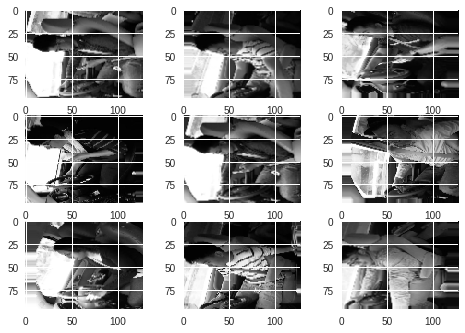

In [76]:
###############################################################################
# Image augmentation steps    


datagen = ImageDataGenerator(
       rotation_range=0.2, height_shift_range=0.05, shear_range=0.75, channel_shift_range=0.00001, width_shift_range=0.1)

datagen.fit(x_train)

 
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(img_rows, img_cols), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break


###############################################################################


In [0]:
# Set model batch size and epoch parameters.
batch_size =250
nb_epoch =100

# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 3
# convolution kernel size
nb_conv = 3

In [78]:
# create a convolution model with keras

from keras.optimizers import SGD, Adam, Adadelta, Adamax

# Key to select if using as-is data(transposed, resize, grey scale) Or
# if using augmented data.  (0 for as-is, 1 for augmented)

augm_data = 0

print(batch_size)

activation = 'relu'


# read saved model, if any
model_from_cache = 0
if model_from_cache == 1:
    model = read_model()
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')
else:
    model = Sequential()
    model.add(BatchNormalization(axis=1, input_shape=(color_type,img_rows, img_cols)))
    # first convolution layer
    model.add(Convolution2D(nb_filters, (nb_conv, nb_conv),
                            padding="same",
                            input_shape=(1, img_rows, img_cols), data_format = 'channels_first'))
    
    model.add(Activation(activation))
    #model.add(Convolution2D(nb_filters, (1, 1)))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.2))
    
  
    # flatten and dropout layers
    model.add(Flatten())
    
    model.add(Dense(512))
    model.add(Activation(activation))
    model.add(Dropout(0.4))
    
    model.add(Dense(128))
    model.add(Activation(activation))
    model.add(Dropout(0.3))
    
    # fully connected layer with softmax for probablities
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    model.summary()
    
    adadel = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    
    sgd = SGD(lr=0.0005, momentum=0.4, decay=0.0000001, nesterov=True)
    
    
    adam =  Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    
    # compile and train model
    model.compile(loss='categorical_crossentropy', optimizer= sgd, metrics=['accuracy'])

    if augm_data ==  0:
        # For Non-augmented data
        history2 = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epoch,
                  verbose=1, validation_data=(x_valid, y_valid))
    else:
    # for augmented data
        history2 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                            epochs=nb_epoch,
                            verbose=1, steps_per_epoch=len(x_train)/batch_size, 
                            validation_data=(x_valid, y_valid))

model.summary()  # get model summary
 
###############################################################################





250
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 1, 96, 128)        4         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 96, 128)       320       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 96, 128)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 42)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 42)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 43008)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               22020608  
______

20010/20010 [==============================] - 12s 610us/step - loss: 2.3192 - acc: 0.1125 - val_loss: 2.2931 - val_acc: 0.1321
Epoch 2/100
20010/20010 [==============================] - 11s 565us/step - loss: 2.2953 - acc: 0.1247 - val_loss: 2.2808 - val_acc: 0.1558
Epoch 3/100
20010/20010 [==============================] - 11s 563us/step - loss: 2.2753 - acc: 0.1443 - val_loss: 2.2729 - val_acc: 0.1732
Epoch 4/100
20010/20010 [==============================] - 11s 563us/step - loss: 2.2575 - acc: 0.1585 - val_loss: 2.2591 - val_acc: 0.1901
Epoch 5/100
 3000/20010 [===>..........................] - ETA: 9s - loss: 2.2479 - acc: 0.1767

20010/20010 [==============================] - 11s 562us/step - loss: 2.2443 - acc: 0.1782 - val_loss: 2.2428 - val_acc: 0.2303
Epoch 6/100
20010/20010 [==============================] - 11s 563us/step - loss: 2.2198 - acc: 0.1992 - val_loss: 2.2266 - val_acc: 0.2423
Epoch 7/100
20010/20010 [==============================] - 11s 562us/step - loss: 2.2005 - acc: 0.2072 - val_loss: 2.2057 - val_acc: 0.2552
Epoch 8/100
20010/20010 [==============================] - 11s 565us/step - loss: 2.1726 - acc: 0.2288 - val_loss: 2.1866 - val_acc: 0.2817
Epoch 9/100
 2000/20010 [=>............................] - ETA: 9s - loss: 2.1499 - acc: 0.2495

20010/20010 [==============================] - 11s 564us/step - loss: 2.1458 - acc: 0.2470 - val_loss: 2.1681 - val_acc: 0.2991
Epoch 10/100
20010/20010 [==============================] - 11s 565us/step - loss: 2.1143 - acc: 0.2695 - val_loss: 2.1475 - val_acc: 0.2949
Epoch 11/100
20010/20010 [==============================] - 11s 565us/step - loss: 2.0803 - acc: 0.2823 - val_loss: 2.1206 - val_acc: 0.2738
Epoch 12/100
20010/20010 [==============================] - 11s 565us/step - loss: 2.0456 - acc: 0.3000 - val_loss: 2.0938 - val_acc: 0.2945
Epoch 13/100
 1750/20010 [=>............................] - ETA: 9s - loss: 2.0009 - acc: 0.3314

20010/20010 [==============================] - 11s 564us/step - loss: 2.0027 - acc: 0.3174 - val_loss: 2.0774 - val_acc: 0.3144
Epoch 14/100
20010/20010 [==============================] - 11s 565us/step - loss: 1.9592 - acc: 0.3416 - val_loss: 2.0442 - val_acc: 0.2954
Epoch 15/100
20010/20010 [==============================] - 11s 563us/step - loss: 1.9153 - acc: 0.3599 - val_loss: 2.0109 - val_acc: 0.3082
Epoch 16/100
20010/20010 [==============================] - 11s 563us/step - loss: 1.8675 - acc: 0.3785 - val_loss: 1.9760 - val_acc: 0.3202
Epoch 17/100
 1750/20010 [=>............................] - ETA: 9s - loss: 1.8372 - acc: 0.3971 

20010/20010 [==============================] - 11s 565us/step - loss: 1.8232 - acc: 0.3921 - val_loss: 1.9476 - val_acc: 0.3231
Epoch 18/100
20010/20010 [==============================] - 11s 561us/step - loss: 1.7736 - acc: 0.4077 - val_loss: 1.9413 - val_acc: 0.3198
Epoch 19/100
20010/20010 [==============================] - 11s 565us/step - loss: 1.7258 - acc: 0.4289 - val_loss: 1.9198 - val_acc: 0.3268
Epoch 20/100
20010/20010 [==============================] - 11s 565us/step - loss: 1.6715 - acc: 0.4461 - val_loss: 1.8917 - val_acc: 0.3306
Epoch 21/100
 1750/20010 [=>............................] - ETA: 9s - loss: 1.6656 - acc: 0.4503

20010/20010 [==============================] - 11s 562us/step - loss: 1.6182 - acc: 0.4666 - val_loss: 1.8704 - val_acc: 0.3256
Epoch 22/100
20010/20010 [==============================] - 11s 566us/step - loss: 1.5649 - acc: 0.4852 - val_loss: 1.8555 - val_acc: 0.3380
Epoch 23/100
20010/20010 [==============================] - 11s 565us/step - loss: 1.5129 - acc: 0.5027 - val_loss: 1.8325 - val_acc: 0.3579
Epoch 24/100
20010/20010 [==============================] - 11s 563us/step - loss: 1.4577 - acc: 0.5234 - val_loss: 1.8211 - val_acc: 0.3368
Epoch 25/100
 1750/20010 [=>............................] - ETA: 9s - loss: 1.4307 - acc: 0.5286 

20010/20010 [==============================] - 11s 563us/step - loss: 1.4074 - acc: 0.5422 - val_loss: 1.8342 - val_acc: 0.3372
Epoch 26/100
20010/20010 [==============================] - 11s 561us/step - loss: 1.3717 - acc: 0.5507 - val_loss: 1.7464 - val_acc: 0.3703
Epoch 27/100
20010/20010 [==============================] - 11s 565us/step - loss: 1.3170 - acc: 0.5687 - val_loss: 1.7373 - val_acc: 0.3882
Epoch 28/100
20010/20010 [==============================] - 11s 564us/step - loss: 1.2646 - acc: 0.5903 - val_loss: 1.7437 - val_acc: 0.3650
Epoch 29/100
 1750/20010 [=>............................] - ETA: 9s - loss: 1.2652 - acc: 0.5834

20010/20010 [==============================] - 11s 566us/step - loss: 1.2280 - acc: 0.6023 - val_loss: 1.7576 - val_acc: 0.3927
Epoch 30/100
20010/20010 [==============================] - 11s 562us/step - loss: 1.1881 - acc: 0.6156 - val_loss: 1.8934 - val_acc: 0.3339
Epoch 31/100
20010/20010 [==============================] - 11s 566us/step - loss: 1.1499 - acc: 0.6257 - val_loss: 1.8298 - val_acc: 0.3869
Epoch 32/100
20010/20010 [==============================] - 11s 566us/step - loss: 1.1038 - acc: 0.6486 - val_loss: 1.6989 - val_acc: 0.3811
Epoch 33/100
 1750/20010 [=>............................] - ETA: 9s - loss: 1.1085 - acc: 0.6480

20010/20010 [==============================] - 11s 563us/step - loss: 1.0744 - acc: 0.6571 - val_loss: 1.7180 - val_acc: 0.4068
Epoch 34/100
20010/20010 [==============================] - 11s 563us/step - loss: 1.0312 - acc: 0.6662 - val_loss: 1.6994 - val_acc: 0.4010
Epoch 35/100
20010/20010 [==============================] - 11s 564us/step - loss: 1.0010 - acc: 0.6802 - val_loss: 1.7399 - val_acc: 0.4196
Epoch 36/100
20010/20010 [==============================] - 11s 562us/step - loss: 0.9622 - acc: 0.6927 - val_loss: 1.7035 - val_acc: 0.4325
Epoch 37/100
 1750/20010 [=>............................] - ETA: 10s - loss: 0.9530 - acc: 0.7046

20010/20010 [==============================] - 11s 569us/step - loss: 0.9291 - acc: 0.7036 - val_loss: 1.6613 - val_acc: 0.4192
Epoch 38/100
20010/20010 [==============================] - 11s 565us/step - loss: 0.8997 - acc: 0.7115 - val_loss: 1.6655 - val_acc: 0.4383
Epoch 39/100
20010/20010 [==============================] - 11s 564us/step - loss: 0.8719 - acc: 0.7225 - val_loss: 1.6973 - val_acc: 0.4383
Epoch 40/100
20010/20010 [==============================] - 11s 564us/step - loss: 0.8338 - acc: 0.7366 - val_loss: 1.7431 - val_acc: 0.4163
Epoch 41/100
 1750/20010 [=>............................] - ETA: 9s - loss: 0.8347 - acc: 0.7314

20010/20010 [==============================] - 11s 564us/step - loss: 0.8212 - acc: 0.7402 - val_loss: 1.7636 - val_acc: 0.4354
Epoch 42/100
20010/20010 [==============================] - 11s 563us/step - loss: 0.7832 - acc: 0.7525 - val_loss: 1.7352 - val_acc: 0.4408
Epoch 43/100
20010/20010 [==============================] - 11s 565us/step - loss: 0.7673 - acc: 0.7582 - val_loss: 1.7264 - val_acc: 0.4474
Epoch 44/100
20010/20010 [==============================] - 11s 563us/step - loss: 0.7356 - acc: 0.7743 - val_loss: 1.6189 - val_acc: 0.4611
Epoch 45/100
 1750/20010 [=>............................] - ETA: 9s - loss: 0.7469 - acc: 0.7703

20010/20010 [==============================] - 11s 564us/step - loss: 0.7165 - acc: 0.7807 - val_loss: 1.7444 - val_acc: 0.4503
Epoch 46/100
20010/20010 [==============================] - 11s 564us/step - loss: 0.6934 - acc: 0.7812 - val_loss: 1.7766 - val_acc: 0.4379
Epoch 47/100
20010/20010 [==============================] - 11s 563us/step - loss: 0.6718 - acc: 0.7910 - val_loss: 1.7071 - val_acc: 0.4569
Epoch 48/100
20010/20010 [==============================] - 11s 565us/step - loss: 0.6559 - acc: 0.7983 - val_loss: 1.6613 - val_acc: 0.4727
Epoch 49/100
 1750/20010 [=>............................] - ETA: 9s - loss: 0.6427 - acc: 0.8057 

20010/20010 [==============================] - 11s 565us/step - loss: 0.6282 - acc: 0.8080 - val_loss: 1.6573 - val_acc: 0.4710
Epoch 50/100
20010/20010 [==============================] - 11s 563us/step - loss: 0.6125 - acc: 0.8124 - val_loss: 1.7137 - val_acc: 0.4511
Epoch 51/100
20010/20010 [==============================] - 11s 566us/step - loss: 0.6045 - acc: 0.8125 - val_loss: 1.7226 - val_acc: 0.4801
Epoch 52/100
20010/20010 [==============================] - 11s 562us/step - loss: 0.5796 - acc: 0.8217 - val_loss: 1.6820 - val_acc: 0.4797
Epoch 53/100
 1750/20010 [=>............................] - ETA: 9s - loss: 0.5946 - acc: 0.8171 

20010/20010 [==============================] - 11s 564us/step - loss: 0.5618 - acc: 0.8297 - val_loss: 1.7100 - val_acc: 0.4789
Epoch 54/100
20010/20010 [==============================] - 11s 564us/step - loss: 0.5376 - acc: 0.8360 - val_loss: 1.6852 - val_acc: 0.4772
Epoch 55/100
20010/20010 [==============================] - 11s 562us/step - loss: 0.5363 - acc: 0.8360 - val_loss: 1.7546 - val_acc: 0.4793
Epoch 56/100
20010/20010 [==============================] - 11s 563us/step - loss: 0.5253 - acc: 0.8374 - val_loss: 1.7321 - val_acc: 0.4909
Epoch 57/100
 1750/20010 [=>............................] - ETA: 9s - loss: 0.5175 - acc: 0.8366

20010/20010 [==============================] - 11s 565us/step - loss: 0.5031 - acc: 0.8450 - val_loss: 1.5958 - val_acc: 0.4901
Epoch 58/100
20010/20010 [==============================] - 11s 563us/step - loss: 0.5014 - acc: 0.8466 - val_loss: 1.7244 - val_acc: 0.4872
Epoch 59/100
20010/20010 [==============================] - 11s 564us/step - loss: 0.4722 - acc: 0.8578 - val_loss: 1.6839 - val_acc: 0.4880
Epoch 60/100
20010/20010 [==============================] - 11s 564us/step - loss: 0.4708 - acc: 0.8549 - val_loss: 1.6940 - val_acc: 0.5037
Epoch 61/100
 1750/20010 [=>............................] - ETA: 9s - loss: 0.4688 - acc: 0.8497

20010/20010 [==============================] - 11s 563us/step - loss: 0.4623 - acc: 0.8633 - val_loss: 1.7874 - val_acc: 0.4834
Epoch 62/100
20010/20010 [==============================] - 11s 566us/step - loss: 0.4539 - acc: 0.8612 - val_loss: 1.6982 - val_acc: 0.5166
Epoch 63/100
20010/20010 [==============================] - 11s 563us/step - loss: 0.4374 - acc: 0.8674 - val_loss: 1.7657 - val_acc: 0.5008
Epoch 64/100
20010/20010 [==============================] - 11s 564us/step - loss: 0.4276 - acc: 0.8705 - val_loss: 1.7623 - val_acc: 0.5058
Epoch 65/100
 1750/20010 [=>............................] - ETA: 9s - loss: 0.4112 - acc: 0.8800 

20010/20010 [==============================] - 11s 562us/step - loss: 0.4122 - acc: 0.8790 - val_loss: 1.7044 - val_acc: 0.5182
Epoch 66/100
20010/20010 [==============================] - 11s 563us/step - loss: 0.4077 - acc: 0.8776 - val_loss: 1.6628 - val_acc: 0.5311
Epoch 67/100
20010/20010 [==============================] - 11s 563us/step - loss: 0.3961 - acc: 0.8816 - val_loss: 1.6790 - val_acc: 0.5282
Epoch 68/100
20010/20010 [==============================] - 11s 565us/step - loss: 0.3861 - acc: 0.8854 - val_loss: 1.6925 - val_acc: 0.5203
Epoch 69/100
 1750/20010 [=>............................] - ETA: 9s - loss: 0.3898 - acc: 0.8777

20010/20010 [==============================] - 11s 562us/step - loss: 0.3737 - acc: 0.8882 - val_loss: 1.6244 - val_acc: 0.5211
Epoch 70/100
20010/20010 [==============================] - 11s 564us/step - loss: 0.3733 - acc: 0.8882 - val_loss: 1.6771 - val_acc: 0.5331
Epoch 71/100
20010/20010 [==============================] - 11s 566us/step - loss: 0.3643 - acc: 0.8909 - val_loss: 1.6480 - val_acc: 0.5278
Epoch 72/100
20010/20010 [==============================] - 11s 565us/step - loss: 0.3568 - acc: 0.8948 - val_loss: 1.6670 - val_acc: 0.5269
Epoch 73/100
 1750/20010 [=>............................] - ETA: 9s - loss: 0.3650 - acc: 0.8909 

20010/20010 [==============================] - 11s 565us/step - loss: 0.3453 - acc: 0.8974 - val_loss: 1.6680 - val_acc: 0.5203
Epoch 74/100
20010/20010 [==============================] - 11s 562us/step - loss: 0.3415 - acc: 0.8997 - val_loss: 1.6171 - val_acc: 0.5497
Epoch 75/100
20010/20010 [==============================] - 11s 564us/step - loss: 0.3376 - acc: 0.8990 - val_loss: 1.6413 - val_acc: 0.5406
Epoch 76/100
20010/20010 [==============================] - 11s 561us/step - loss: 0.3267 - acc: 0.9030 - val_loss: 1.6581 - val_acc: 0.5331
Epoch 77/100
 1750/20010 [=>............................] - ETA: 9s - loss: 0.3577 - acc: 0.9023 

20010/20010 [==============================] - 11s 565us/step - loss: 0.3229 - acc: 0.9062 - val_loss: 1.6506 - val_acc: 0.5356
Epoch 78/100
20010/20010 [==============================] - 11s 566us/step - loss: 0.3184 - acc: 0.9058 - val_loss: 1.6784 - val_acc: 0.5365
Epoch 79/100
20010/20010 [==============================] - 11s 562us/step - loss: 0.3065 - acc: 0.9099 - val_loss: 1.7121 - val_acc: 0.5534
Epoch 80/100
20010/20010 [==============================] - 11s 563us/step - loss: 0.2983 - acc: 0.9095 - val_loss: 1.6919 - val_acc: 0.5327
Epoch 81/100
 1750/20010 [=>............................] - ETA: 9s - loss: 0.3042 - acc: 0.9126

20010/20010 [==============================] - 11s 563us/step - loss: 0.2964 - acc: 0.9153 - val_loss: 1.7013 - val_acc: 0.5472
Epoch 82/100
20010/20010 [==============================] - 11s 566us/step - loss: 0.2938 - acc: 0.9136 - val_loss: 1.7234 - val_acc: 0.5464
Epoch 83/100
20010/20010 [==============================] - 11s 562us/step - loss: 0.2865 - acc: 0.9163 - val_loss: 1.7025 - val_acc: 0.5311
Epoch 84/100
20010/20010 [==============================] - 11s 565us/step - loss: 0.2856 - acc: 0.9175 - val_loss: 1.6959 - val_acc: 0.5476
Epoch 85/100
 1750/20010 [=>............................] - ETA: 9s - loss: 0.2682 - acc: 0.9240 

20010/20010 [==============================] - 11s 564us/step - loss: 0.2776 - acc: 0.9162 - val_loss: 1.6714 - val_acc: 0.5493
Epoch 86/100
20010/20010 [==============================] - 11s 564us/step - loss: 0.2772 - acc: 0.9158 - val_loss: 1.6513 - val_acc: 0.5613
Epoch 87/100
20010/20010 [==============================] - 11s 564us/step - loss: 0.2715 - acc: 0.9205 - val_loss: 1.7902 - val_acc: 0.5174
Epoch 88/100
20010/20010 [==============================] - 11s 566us/step - loss: 0.2669 - acc: 0.9216 - val_loss: 1.6667 - val_acc: 0.5655
Epoch 89/100
 1750/20010 [=>............................] - ETA: 9s - loss: 0.2663 - acc: 0.9177 

20010/20010 [==============================] - 11s 563us/step - loss: 0.2663 - acc: 0.9210 - val_loss: 1.7129 - val_acc: 0.5327
Epoch 90/100
20010/20010 [==============================] - 11s 563us/step - loss: 0.2563 - acc: 0.9246 - val_loss: 1.6488 - val_acc: 0.5642
Epoch 91/100
20010/20010 [==============================] - 11s 562us/step - loss: 0.2480 - acc: 0.9292 - val_loss: 1.6517 - val_acc: 0.5650
Epoch 92/100
20010/20010 [==============================] - 11s 562us/step - loss: 0.2460 - acc: 0.9273 - val_loss: 1.6860 - val_acc: 0.5750
Epoch 93/100
 1750/20010 [=>............................] - ETA: 9s - loss: 0.2317 - acc: 0.9297 

20010/20010 [==============================] - 11s 565us/step - loss: 0.2418 - acc: 0.9302 - val_loss: 1.6384 - val_acc: 0.5555
Epoch 94/100
20010/20010 [==============================] - 11s 564us/step - loss: 0.2389 - acc: 0.9307 - val_loss: 1.7157 - val_acc: 0.5518
Epoch 95/100
20010/20010 [==============================] - 11s 563us/step - loss: 0.2313 - acc: 0.9337 - val_loss: 1.6389 - val_acc: 0.5754
Epoch 96/100
20010/20010 [==============================] - 11s 565us/step - loss: 0.2314 - acc: 0.9317 - val_loss: 1.6070 - val_acc: 0.5613
Epoch 97/100
 1750/20010 [=>............................] - ETA: 10s - loss: 0.2272 - acc: 0.9394

20010/20010 [==============================] - 11s 564us/step - loss: 0.2269 - acc: 0.9353 - val_loss: 1.5707 - val_acc: 0.5634
Epoch 98/100
20010/20010 [==============================] - 11s 563us/step - loss: 0.2252 - acc: 0.9346 - val_loss: 1.6001 - val_acc: 0.5679
Epoch 99/100
20010/20010 [==============================] - 11s 565us/step - loss: 0.2192 - acc: 0.9368 - val_loss: 1.6775 - val_acc: 0.5601
Epoch 100/100
20010/20010 [==============================] - 11s 564us/step - loss: 0.2165 - acc: 0.9374 - val_loss: 1.6528 - val_acc: 0.5700
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 1, 96, 128)        4         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 96, 128)       320       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 96, 128)    

In [52]:
# Score model on train and validation sets.
# Create a dataframe to stroe the results from the training
# Plot training results
train_score = model.evaluate(x_train, y_train, verbose=0)
print('train score: ', train_score)

valid_score = model.evaluate(x_valid, y_valid, verbose=0)
print('valid score: ', valid_score)

train score:  [0.028420792114547407, 0.993103448275862]
valid score:  [1.7207373447697718, 0.5526097763048882]


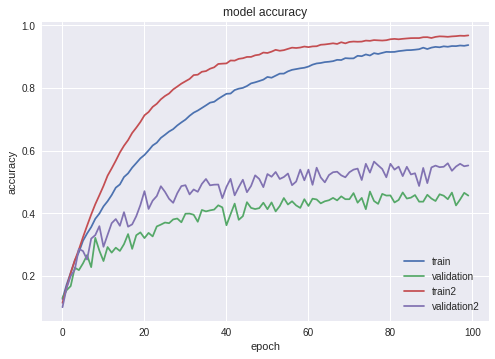

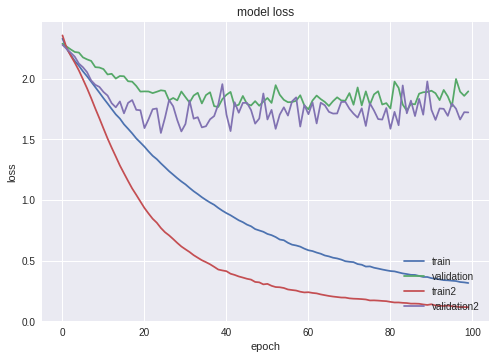

In [53]:
# Create a dataframe to stroe the results from the training for each model
# Plot training results

results_df2 = pd.DataFrame(
    {'train_loss': history2.history['loss'],
     'train_acc': history2.history['acc'],
     'val_loss': history2.history['val_loss'],
     'val_acc': history2.history['val_acc']
    })




# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'train2', 'validation2'], loc='lower right')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'train2', 'validation2'], loc='lower right')
plt.show()

In [54]:
# Print results

print(results_df2[:10])
print(results_df2[90:100])

   train_acc  train_loss   val_acc  val_loss
0   0.113693    2.355307  0.099834  2.277190
1   0.163368    2.253098  0.161143  2.244916
2   0.209495    2.188853  0.199254  2.213029
3   0.249125    2.130565  0.219967  2.179901
4   0.284358    2.066453  0.286247  2.123239
5   0.323538    1.993203  0.279205  2.092710
6   0.360120    1.918909  0.252278  2.051852
7   0.395902    1.838284  0.318973  1.983916
8   0.428886    1.753152  0.330157  1.948413
9   0.457671    1.672362  0.358741  1.930982
    train_acc  train_loss   val_acc  val_loss
90   0.959920    0.139865  0.546396  1.742776
91   0.963418    0.129794  0.552196  1.659108
92   0.965167    0.128574  0.547225  1.753152
93   0.964668    0.125168  0.548467  1.750297
94   0.963668    0.129375  0.559652  1.692505
95   0.965017    0.123851  0.535626  1.793181
96   0.965817    0.121069  0.549296  1.751212
97   0.967216    0.116450  0.557995  1.662391
98   0.966717    0.116937  0.550124  1.722590
99   0.968166    0.115584  0.552610  1.720737

In [0]:
# Name the model type to id weights and results
Model_type2 = "simple_Conv"

In [56]:
# Save weights if model is acceptable

# serialize weights to HDF5
weights_filename = 'drive/Colab_Notebooks/Models/' + Model_type2 + "_" + train_data_filename + '_weights.h5'
print(str(weights_filename))
model.save_weights(weights_filename)

#model.save_weights(str(train_data_filename +".h5"))
#print("Saved model to disk")

drive/Colab_Notebooks/Models/simple_Conv_p075_p014_p045_1_96_128_weights.h5


In [57]:
# Save the training results file
results_filename2 = 'drive/Colab_Notebooks/Results/' + Model_type2 + "_" + train_data_filename + '_results.csv'
print(results_filename2)
results_df2.to_csv(results_filename2, sep=',')

drive/Colab_Notebooks/Results/simple_Conv_p075_p014_p045_1_96_128_results.csv


In [0]:
from skimage.transform import rotate
def show_image(image):
    img = image.squeeze()
    plt.axis("off")
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(np.fliplr(rotate(img, 270)), cmap='gray', interpolation='nearest')  
    # Manipulation to display image in the correct orientation!
    plt.show() 
    #print image.shape
    #plt.imshow(image)

20010/20010 [==============================] - 4s 199us/step


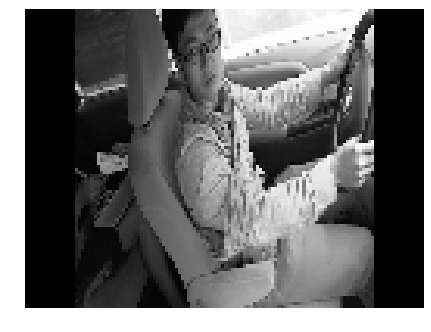

y_train true array: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
y_train true class: c9
y_train predicted array: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
y_train predicted class: c9


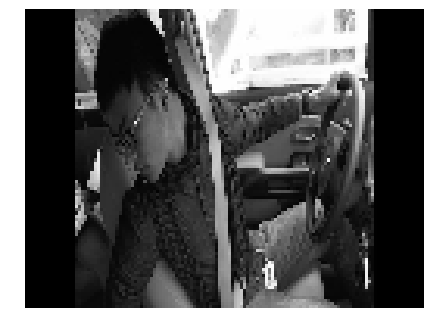

y_train true array: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
y_train true class: c7
y_train predicted array: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
y_train predicted class: c7


In [59]:


# predict on train set just to verify accuracy
train_predict_probs = model.predict(x_train, batch_size = batch_size, verbose = 1)

# convert prediction probabilities to class array for train set
y_train_predicted2= predictions_results(train_predict_probs)


# convert the true and predicted array into classes

# For train data 

train_true_classes = np.argmax(y_train,  axis=1)
train_pred_classes2 = np.argmax(y_train_predicted2,  axis=1)


# View some actual and predicted examples train set
for num in np.random.choice(len(y_train),2, replace = False):
    show_image(x_train[num])
    print("y_train true array:", y_train[num])
    print("y_train true class: c" + str(train_true_classes[num]))
    print("y_train predicted array:", y_train_predicted2[num])
    print("y_train predicted class: c" + str(train_pred_classes2[num]))

2414/2414 [==============================] - 0s 189us/step
[1.2471656e-01 2.5100971e-05 9.2163612e-04 2.9004769e-02 7.7711195e-01
 1.3028573e-02 1.0618021e-03 3.1722934e-04 4.2225145e-02 1.1587296e-02]
          0         1         2         3         4         5         6  \
1  0.124717  0.000025  0.000922  0.029005  0.777112  0.013029  0.001062   
2  0.116041  0.000030  0.000963  0.030859  0.793112  0.013826  0.001394   
3  0.152563  0.000101  0.010846  0.057082  0.342173  0.160547  0.007434   
4  0.047194  0.000011  0.000330  0.011464  0.917907  0.004998  0.000654   

          7         8         9  
1  0.000317  0.042225  0.011587  
2  0.000354  0.031280  0.012142  
3  0.002275  0.132235  0.134744  
4  0.000105  0.015058  0.002278  


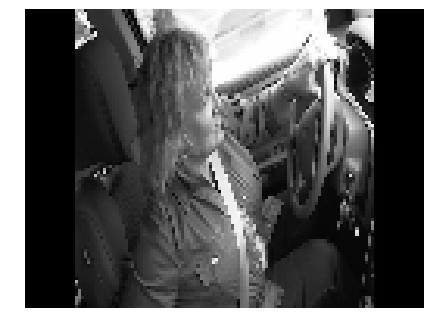

y_valid true array: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
y_valid true class: c7
y_valid predicted array: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
y_valid predicted class: c8


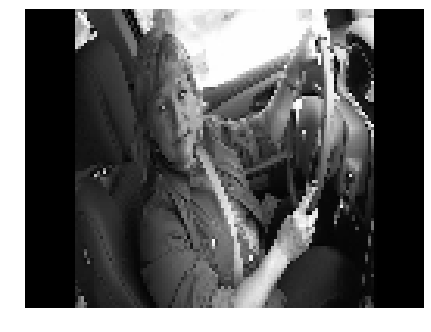

y_valid true array: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
y_valid true class: c9
y_valid predicted array: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
y_valid predicted class: c9


In [60]:
# Verify predictions for validation set
# collect predictions on valid set
# Store probs in a dataframe and csv for later use
valid_prediction_probs = model.predict(x_valid, batch_size = batch_size, verbose = 1)
print(valid_prediction_probs[1])

valid_probs_df= pd.DataFrame(valid_prediction_probs)
print(valid_probs_df[1:5])
valid_probs_filename = 'drive/Colab_Notebooks/Results/' + Model_type2 + "_" + train_data_filename + '_valid_probs.csv'
valid_probs_df.to_csv(valid_probs_filename, sep=',')


# convert prediction probabilities to class array for validation set
y_valid_predicted= predictions_results(valid_prediction_probs)
#print(y_valid_predicted[1])


# convert the true and predicted array into classes
# for validation set

valid_true_classes = np.argmax(y_valid,  axis=1)
valid_pred_classes = np.argmax(y_valid_predicted,  axis=1)



# View some actual and predicted examples validation set
for num in np.random.choice(len(y_valid), 2, replace = False):
    show_image(x_valid[num])
    print("y_valid true array:", y_valid[num])
    print("y_valid true class: c" + str(valid_true_classes[num]))
    print("y_valid predicted array:", y_valid_predicted[num])
    print("y_valid predicted class: c" + str(valid_pred_classes[num]))


###############################################################################

In [61]:
# Add the validation predictions to valid_driver_list
# Add the true classes for now to ensure that the order of valid_driver_list and predictions is same.
#valid_df= pd.DataFrame()
valid_df['true'] = valid_true_classes
valid_df['pred'] = valid_pred_classes
valid_filename = 'drive/Colab_Notebooks/Results/' + Model_type2 + "_" + train_data_filename + '_valid.csv'
print(valid_filename)
print(valid_df.head(n=5))
valid_df.to_csv(valid_filename, sep=',')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


drive/Colab_Notebooks/Results/simple_Conv_p075_p014_p045_1_96_128_valid.csv
     subject classname             img  true  pred
1548    p014        c0   img_72495.jpg     0     4
1549    p014        c0   img_62101.jpg     0     4
1550    p014        c0   img_34774.jpg     0     4
1551    p014        c0  img_100312.jpg     0     4
1552    p014        c0   img_12279.jpg     0     4


Confusion matrix, without normalization
[[2161   13    7    6   17    1    9    4    4   10]
 [   6 1987    6    1    2    0    5    3    3    1]
 [   7    6 2033    0    1    0   10    3    4    1]
 [   6    2    6 2063    9    0    0    0    0    1]
 [  10    5    6    7 2026    0    5    1    5    4]
 [  15    0    1    0    7 2020    4    1    0    3]
 [   7    8   15    1    5    2 2018    6    6    0]
 [   3    1    7    1    2    2    8 1709   17    4]
 [  19    3   17   17   19    0    9   13 1552   43]
 [  18    2    1    3    3    6    1    4   28 1823]]
Normalized confusion matrix
[[9.68e-01 5.82e-03 3.14e-03 2.69e-03 7.62e-03 4.48e-04 4.03e-03 1.79e-03
  1.79e-03 4.48e-03]
 [2.98e-03 9.87e-01 2.98e-03 4.97e-04 9.93e-04 0.00e+00 2.48e-03 1.49e-03
  1.49e-03 4.97e-04]
 [3.39e-03 2.91e-03 9.85e-01 0.00e+00 4.84e-04 0.00e+00 4.84e-03 1.45e-03
  1.94e-03 4.84e-04]
 [2.87e-03 9.58e-04 2.87e-03 9.89e-01 4.31e-03 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 4.79e-04]
 [4.83e-03 2.42e-03 2

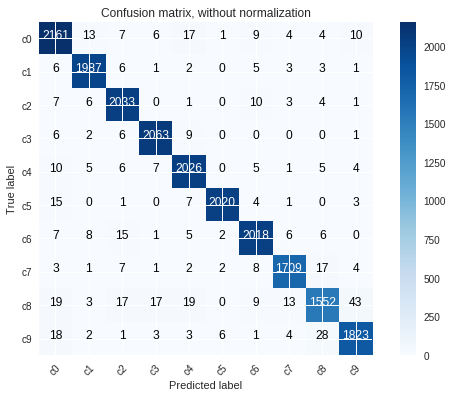

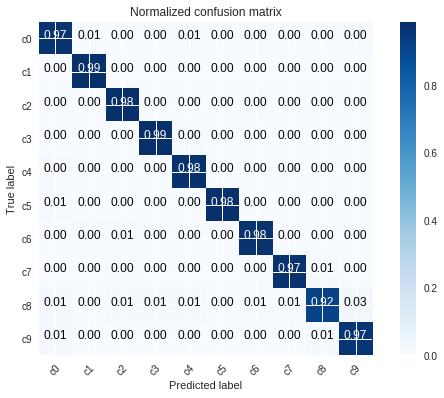

Confusion matrix, without normalization
[[  4   0   0 110  53   0   0   0   1  89]
 [  3 113   0  99   1   0   7   1  13  16]
 [  0  66   2  89  24   0   1  55   6   9]
 [  1   0   1 211  42   0   0   0   0   4]
 [ 40   3   0  13 168   0   0   1   0  32]
 [  1   0   0  13   5 241   0   0   0   1]
 [  0  14  11   1  37   0 161  16   5  12]
 [  0  20   0  24   7   0   1 185   0  11]
 [  2  43   1   9  13   0   1  65  77   8]
 [  4   2   0   0  64   0   2   7   1 160]]
Normalized confusion matrix
[[0.02 0.   0.   0.43 0.21 0.   0.   0.   0.   0.35]
 [0.01 0.45 0.   0.39 0.   0.   0.03 0.   0.05 0.06]
 [0.   0.26 0.01 0.35 0.1  0.   0.   0.22 0.02 0.04]
 [0.   0.   0.   0.81 0.16 0.   0.   0.   0.   0.02]
 [0.16 0.01 0.   0.05 0.65 0.   0.   0.   0.   0.12]
 [0.   0.   0.   0.05 0.02 0.92 0.   0.   0.   0.  ]
 [0.   0.05 0.04 0.   0.14 0.   0.63 0.06 0.02 0.05]
 [0.   0.08 0.   0.1  0.03 0.   0.   0.75 0.   0.04]
 [0.01 0.2  0.   0.04 0.06 0.   0.   0.3  0.35 0.04]
 [0.02 0.01 0.   0.   0.

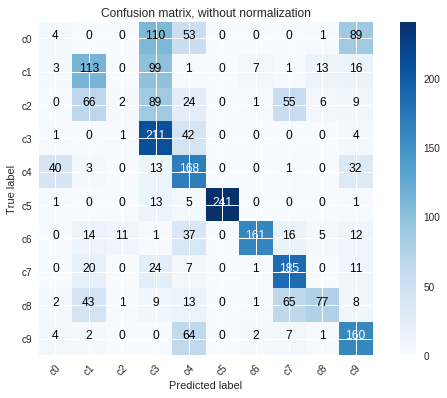

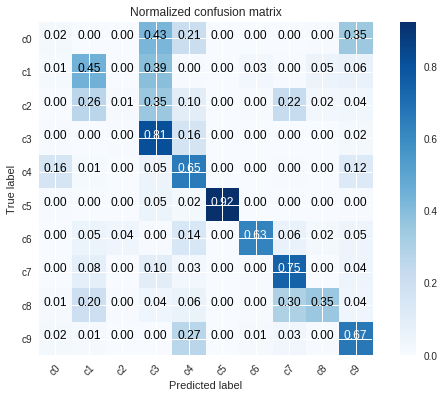

In [62]:

# Confusion Matrix

class_names = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
class_names2 = ['c0', 'c1']


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
    
# Train data
cnf_matrix = confusion_matrix(train_true_classes, train_pred_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


# Valid data

cnf_matrix = confusion_matrix(valid_true_classes, valid_pred_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

###############################################################################

In [63]:
# Metrics

from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(valid_true_classes, valid_pred_classes, average='weighted')


from sklearn.metrics import classification_report
print(classification_report(valid_true_classes, valid_pred_classes, target_names=class_names))


             precision    recall  f1-score   support

         c0       0.07      0.02      0.03       257
         c1       0.43      0.45      0.44       253
         c2       0.13      0.01      0.01       252
         c3       0.37      0.81      0.51       259
         c4       0.41      0.65      0.50       257
         c5       1.00      0.92      0.96       261
         c6       0.93      0.63      0.75       257
         c7       0.56      0.75      0.64       248
         c8       0.75      0.35      0.48       219
         c9       0.47      0.67      0.55       240

avg / total       0.51      0.53      0.49      2503



correct_classfully validated 2454 / 2947 = 83.27112317611129%
Sample of images validated correctly:
***************
Rendering image 1622


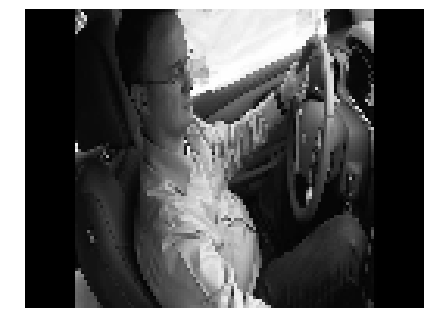

Classified correctly as c5: operating the radio

***************
Rendering image 1941


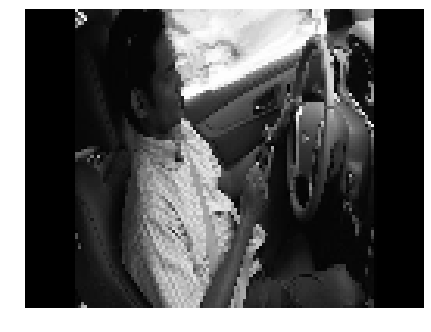

Classified correctly as c1: texting - right

***************
Rendering image 331


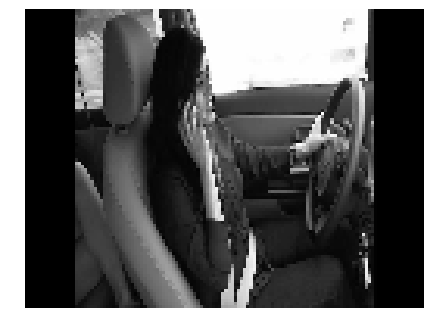

Classified correctly as c2: talking on the phone - right

***************
Rendering image 1321


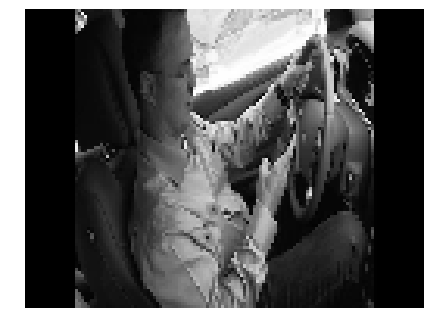

Classified correctly as c1: texting - right

***************
Rendering image 1641


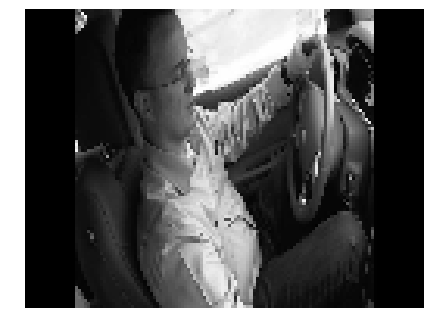

Classified correctly as c5: operating the radio

Sample of images validated incorrectly:
***************
Rendering image 156


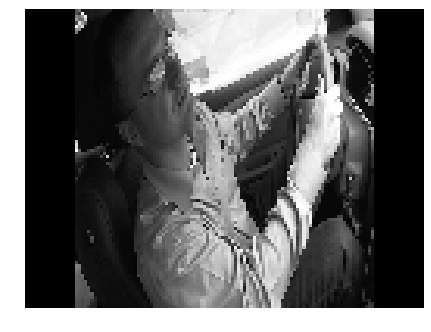

Classified incorrectly as c0: safe driving

***************
Rendering image 315


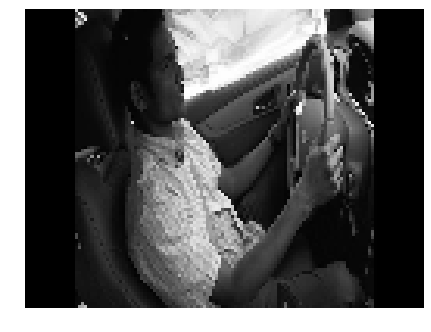

Classified incorrectly as c5: operating the radio

***************
Rendering image 16


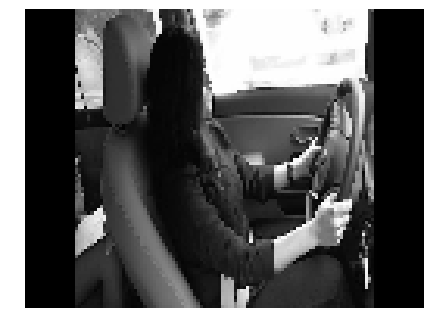

Classified incorrectly as c3: texting - left

***************
Rendering image 93


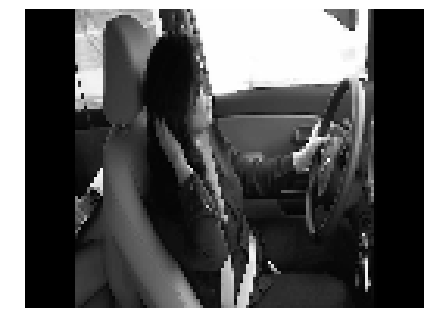

Classified incorrectly as c2: talking on the phone - right

***************
Rendering image 36


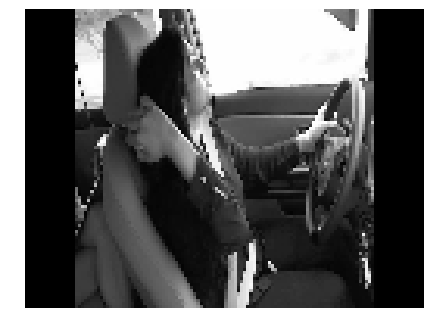

Classified incorrectly as c9: talking to passenger



In [0]:
# compare predicts with actual and count correct and incorrect classificaitons
correct_class = []
wrong_class = []
c = 0

for yc, yp in zip(valid_true_classes, valid_pred_classes):
    if yc == yp:
        #print "correct_class: Class {}, {} predicted".format(np.argmax(yclass), np.argmax(ypredict))
        correct_class.append([c, yp])
    else:
        #print "wrong_class!: Class {}, {} predicted".format(np.argmax(yclass), np.argmax(ypredict))
        wrong_class.append([c, yp])
    c += 1
    
print("correct_classfully validated {} / {} = {}%".format(len(correct_class), c, (float(len(correct_class))/float(c))*100))
#print "correct_class: {}".format(correct_class)
#print "wrong_class: {}".format(wrong_class)

# Create labels to assign to predictions and plot examples
# labels for org data (use for full data or sub1)
labels_org = [  'c0: safe driving',
            'c1: texting - right',
            'c2: talking on the phone - right',
            'c3: texting - left',
            'c4: talking on the phone - left',
            'c5: operating the radio',
            'c6: drinking',
            'c7: reaching behind',
            'c8: hair and makeup',
            'c9: talking to passenger']

# labels for two category sub2 data
labels_sub2 = [  'c0: safe driving',
            'c1: distracted driving']

# set correct labels
labels=labels_org

    
#print correct_class examples

print("Sample of images validated correctly:")
for s in np.random.choice(len(correct_class), 5, replace = False):
    print("***************\nRendering image {}".format(s))
    image = x_valid[correct_class[s][0]]
    show_image(image)
    print("Classified correctly as {}\n".format(labels[np.argmax(y_valid_predicted[correct_class[s][0]])]))
    
    
# print wrong classification examples    
print("Sample of images validated incorrectly:")
for s in np.random.choice(len(wrong_class), 5, replace = False):
    print("***************\nRendering image {}".format(s))
    image = x_valid[wrong_class[s][0]]
    show_image(image)
    print("Classified incorrectly as {}\n".format(labels[np.argmax(y_valid_predicted[wrong_class[s][0]])]))
    

